<a href="https://colab.research.google.com/github/puneat/Algorithmic_Portfolio/blob/master/Portfolio_Investment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
!pip install hmmlearn

     |████████████████████████████████| 368kB 8.4MB/s 


In [5]:
!pip3 install ta

  Created wheel for ta: filename=ta-0.5.25-cp36-none-any.whl size=24880 sha256=f131152456526fcb5b373c7d949da59a53ab47bee0de3d85d7d2b1fd66d423b8
  Stored in directory: /root/.cache/pip/wheels/2e/93/b7/cf649194508e53cee4145ffb949e9f26877a5a8dd12db9ed5b
Successfully built ta


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import pandas as pd
# from ta import add_all_ta_features
# from ta.utils import dropna
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import itertools
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
data = read_price_data(638)
data.head()

VRSK.US Equity


,open,high,low,close,volume,bb_live
date,,,,,,
2007-01-03,1.000000,NaN,NaN,NaN,NaN,NaN
2007-01-04,0.982633,NaN,NaN,NaN,NaN,NaN
2007-01-05,0.973673,NaN,NaN,NaN,NaN,NaN
2007-01-08,0.959063,NaN,NaN,NaN,NaN,NaN
2007-01-09,0.974087,NaN,NaN,NaN,NaN,NaN


In [305]:
from hmmlearn.hmm import GaussianHMM
# data = read_price_data(43)
# returns = data.bb_live[:100].pct_change()
# returns =np.column_stack(returns[1:])
data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')
data['return'] = data['SPX Index'].pct_change()
data=data.dropna()
returns =np.vstack(data['return'])
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=5000).fit(returns[:100])

In [59]:
print("Model Score:", hmm_model.score(returns))

Model Score: 6748.508002043049


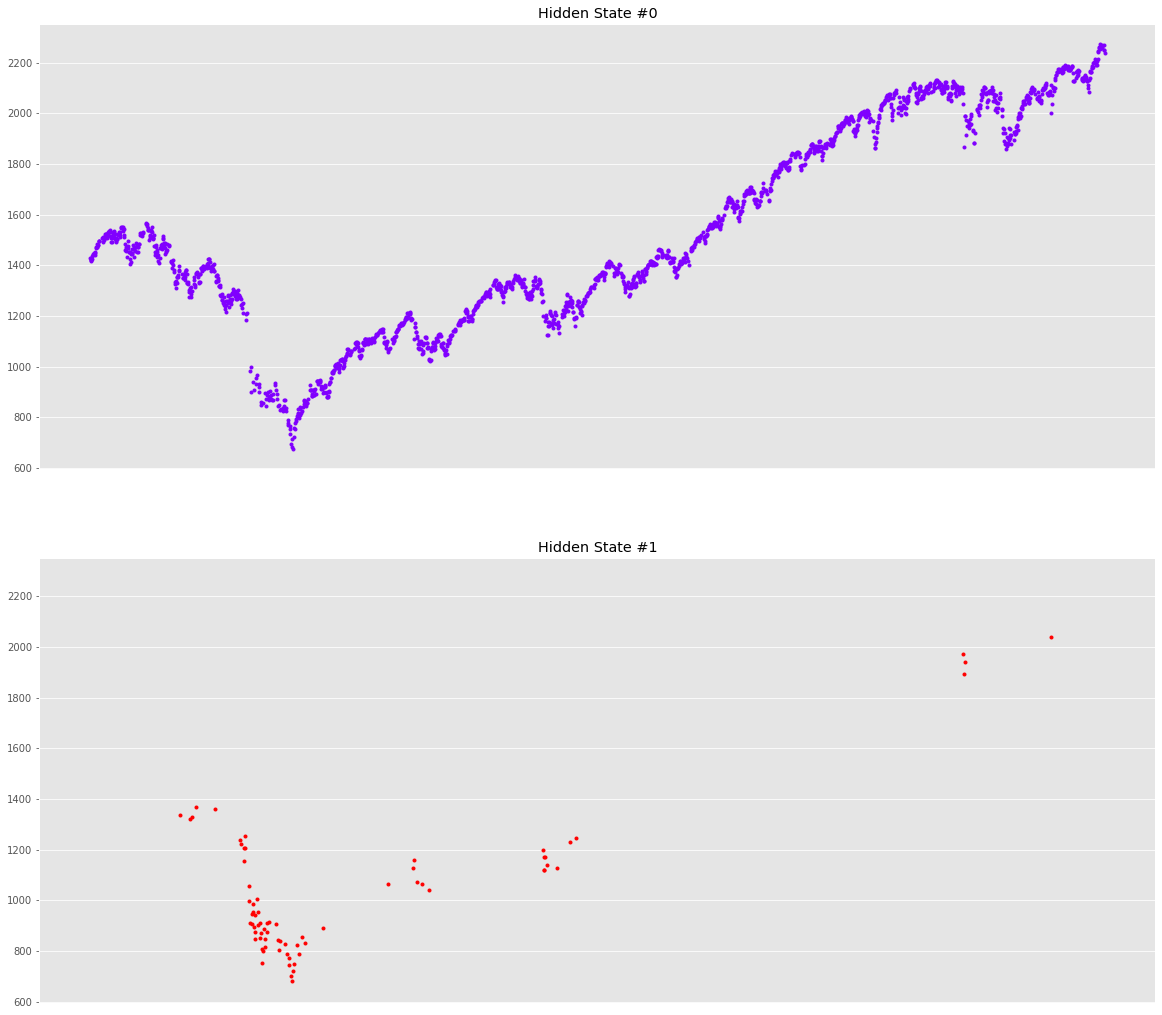

In [306]:
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns
# Predict the hidden states array
hidden_states = hmm_model.predict(returns)
# Create the correctly formatted plot
matplotlib.style.use('ggplot')
fig, axs = plt.subplots(hmm_model.n_components, sharex=True, sharey=True,figsize=(20, 18))
colours = cm.rainbow(np.linspace(0, 1, hmm_model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
  mask = hidden_states == i
  ax.plot_date(data.index[mask], data["SPX Index"][mask], ".", linestyle='none', c=colour)
  ax.set_title("Hidden State #%s" % i)
  ax.xaxis.set_major_locator(YearLocator())
  ax.xaxis.set_minor_locator(MonthLocator())
  ax.grid(True)
plt.show()

In [301]:
hidden_states = hmm_model.predict(returns[705:740])
hidden_states

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [64]:
data = read_price_data(43)
logic = {'open'  : 'first',
         'high'  : 'max',
         'low'   : 'min',
         'close' : 'last',
         'volume': 'sum',
         'bb_live':'last'}

offset = pd.offsets.timedelta(days=-6)

#data = pd.read_clipboard(parse_dates=['date'], index_col=['date'])
data = data.resample('W', loffset=offset).apply(logic)
data.head()

AMZN.US Equity


,open,high,low,close,volume,bb_live
date,,,,,,
2007-01-01,1.000000,1.002048,0.988173,0.991473,25393717.0,0.991473
2007-01-08,1.007385,0.980799,0.974244,0.987080,29952875.0,0.987080
2007-01-15,1.017332,0.998464,0.961892,0.956589,25899684.0,0.956589
2007-01-22,1.081236,0.978751,0.954008,0.952196,29809161.0,0.952196
2007-01-29,1.112283,1.006144,0.960315,0.966150,71727278.0,0.966150


In [34]:
data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/bb_live.csv')
print(data.shape)
data=data.dropna(axis = 1, thresh=2518) 
print(data.shape)
data['date'] = pd.to_datetime(data['date'])
data=data.set_index('date')
data=data.pct_change()
data=data.dropna(axis = 0) 
data=data.head(30)
print(data.shape)
data.head()

(2524, 680)
(2524, 507)
(30, 506)


,A.US Equity,AAP.US Equity,AAPL.US Equity,ABC.US Equity,ABT.US Equity,ACAS.US Equity,ACN.US Equity,ADBE.US Equity,ADI.US Equity,ADM.US Equity,ADP.US Equity,ADS.US Equity,ADSK.US Equity,AEE.US Equity,AEP.US Equity,AES.US Equity,AET.US Equity,AFL.US Equity,AGN.US Equity,AIG.US Equity,AIV.US Equity,AIZ.US Equity,AJG.US Equity,AKAM.US Equity,AKS.US Equity,ALB.US Equity,ALK.US Equity,ALL.US Equity,ALXN.US Equity,AMAT.US Equity,AMD.US Equity,AME.US Equity,AMG.US Equity,AMGN.US Equity,AMP.US Equity,AMT.US Equity,AMZN.US Equity,AN.US Equity,ANDV.US Equity,ANF.US Equity,...,VFC.US Equity,VIAB.US Equity,VIAC.US Equity,VIAV.US Equity,VLO.US Equity,VMC.US Equity,VNO.US Equity,VRSN.US Equity,VTR.US Equity,VZ.US Equity,WAT.US Equity,WBA.US Equity,WDC.US Equity,WEC.US Equity,WELL.US Equity,WEN.US Equity,WFC.US Equity,WFM.US Equity,WHR.US Equity,WIN.US Equity,WLTW.US Equity,WM.US Equity,WMB.US Equity,WMT.US Equity,WU.US Equity,WY.US Equity,WYND.US Equity,WYNN.US Equity,X.US Equity,XEC.US Equity,XEL.US Equity,XL.US Equity,XLNX.US Equity,XOM.US Equity,XRAY.US Equity,XRX.US Equity,YHOO.US Equity,YUM.US Equity,ZBH.US Equity,ZION.US Equity
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-04,0.003207,0.006464,0.022196,0.003904,0.018991,-0.006425,0.022540,0.022545,0.017357,-0.005615,0.010122,0.008430,0.018984,-0.002963,-0.000233,0.000456,-0.017724,-0.011027,0.020152,-0.008870,0.003584,0.009850,-0.004051,0.023622,0.018891,-0.004584,0.019507,0.001226,0.002955,0.020630,0.013832,-0.006293,-0.010861,0.042836,0.006519,-0.003947,0.005168,-0.004231,-0.024163,0.029130,...,0.005625,-0.008177,-0.008544,0.042442,-0.023177,-0.002890,0.002383,0.021188,-0.000714,0.005553,0.006956,0.001954,0.003914,0.000209,0.011147,-0.013621,0.001679,0.033201,0.001063,-0.014789,0.002481,-0.012422,-0.002725,0.004837,0.008807,-0.010069,-0.010126,0.000415,-0.009396,-0.012275,0.000854,-0.005991,0.023719,-0.018756,0.003001,-0.000592,0.048419,-0.002718,0.022309,0.004463
2007-01-05,-0.009300,-0.022061,-0.007121,-0.012098,0.000000,-0.011640,-0.013978,-0.004900,-0.011374,-0.001568,-0.002863,0.000929,0.014517,-0.013559,-0.018674,-0.028702,-0.017094,0.001312,-0.019381,-0.004615,-0.023929,-0.006916,-0.013220,-0.002064,-0.019737,-0.017446,-0.036116,-0.002754,-0.006629,-0.006915,-0.004042,-0.018683,-0.008021,0.002383,-0.001439,-0.008719,-0.013625,-0.014636,0.009997,0.012033,...,-0.006809,0.005577,-0.014044,-0.015059,0.009613,-0.015944,-0.020082,0.000407,-0.012422,-0.017092,-0.011174,-0.014298,-0.030214,-0.020651,0.000230,0.022381,-0.005587,-0.007661,-0.000236,-0.006433,-0.010396,-0.016133,0.005465,-0.008162,-0.025316,-0.003205,-0.000620,0.005918,-0.013024,0.002762,-0.020043,-0.004626,-0.009102,0.007151,0.000000,-0.009473,0.033147,-0.008688,-0.000634,-0.003002
2007-01-08,-0.003520,0.003427,0.004938,0.015745,0.003607,-0.000436,0.014449,-0.004185,0.007872,0.005027,0.000615,-0.001856,-0.003100,0.000941,-0.000714,-0.014071,0.003140,0.000655,-0.001140,0.004917,0.012258,0.000893,-0.018207,-0.003384,0.013423,-0.005114,0.021092,0.001381,-0.027435,0.011784,-0.012177,0.001613,0.013187,-0.007972,0.012432,0.028518,-0.022674,0.000479,0.001370,-0.000676,...,-0.002449,0.017844,0.005180,-0.019252,0.000203,0.006798,-0.011794,-0.006913,0.001933,-0.005126,0.038628,0.004176,0.000503,-0.009159,0.004363,0.011178,-0.002809,-0.008364,-0.001534,0.015108,-0.006753,0.002501,0.006599,-0.008230,-0.016570,0.008806,0.000930,0.018889,0.013482,0.006610,0.000000,-0.003098,0.006263,-0.008056,0.005652,0.016736,0.006489,-0.002406,-0.006475,0.001686
2007-01-09,0.001178,0.008537,0.083070,-0.003229,0.008786,0.016801,-0.002419,-0.020272,-0.001502,-0.024383,-0.003894,0.017354,0.012440,0.003386,0.009522,-0.040913,-0.015411,0.003709,0.002283,-0.003355,0.018435,-0.006066,0.000350,-0.006414,-0.006623,0.005854,0.008262,-0.005209,-0.007624,0.019058,0.009245,0.000000,0.009690,0.004793,0.006051,0.014512,0.007467,0.012931,-0.010949,0.016090,...,0.005768,-0.002606,-0.005153,-0.029446,-0.008710,0.010016

In [6]:
class InvestmentUniverse:
  def __init__(self,universe):
    self.universe = universe

    self.tickers = pd.DataFrame(data=universe.columns,
                                index=pd.RangeIndex(1,universe.T.count()[0]+1),
                                columns=['Ticker'])
    
    self.dates=pd.DataFrame(data=universe.index.values,
                            index=pd.RangeIndex(1,universe.count()[0]+1),
                            columns=['Date'])
    
    self.returns=universe

    self.expected_returns=pd.DataFrame(data=self.returns.mean(),
                                       columns=['ExpectedReturns'])
    
    self.variances=pd.DataFrame(data=self.returns.var(),
                                columns=['variance'])
    
    self.volatilities = pd.DataFrame(data=self.returns.std(),
                                     columns=['volatility'])
    self.correl_mtx = self.returns.corr()

    self.covar_mtx = self.returns.cov()

    self.covar_mtx_diag = pd.DataFrame(data=np.diag(self.returns.var()),
                                       index=self.tickers['Ticker'].values,
                                       columns=self.tickers['Ticker'].values)
    
    self.covar_mtx_offdiag = self.covar_mtx - self.covar_mtx_diag
    
    self.volsumprod_mtx = self.volatilities.dot(self.volatilities.T)

  def get_ticker_count(self):
    return self.tickers.count()[0]

  def get_date_count(self):
    return self.dates.count()[0]

In [7]:
import random
def portfolio_generator(investment_universe, position_list, number_of_simulations):
  blank_data_frame = pd.DataFrame()
  row_index = investment_universe.tickers.index
  columns = tuple(itertools.product(position_list,range(1,number_of_simulations+1)))
  row_index_names = investment_universe.tickers
  columns_names = ['NumOfPosn','SimID']
  a = np.zeros(shape=(investment_universe.get_ticker_count(),number_of_simulations))
  portfolio_generation_mtx = pd.DataFrame(data=a,index=row_index_names,columns=columns)
  # portfolio_generation_mtx = blank_data_frame(len(row_index),
  #                                             len(columns),
  #                                             row_index,
  #                                             columns,
  #                                             row_index_names,
  #                                             columns_names)
  
  for i in range(0,number_of_simulations,1):
    pf_sample = list(random.sample(list(row_index),50))
    for k in range(0,len(pf_sample)):
      portfolio_generation_mtx.iloc[pf_sample[k]-1,i] = 1

  portfolio_generation_mtx.index = investment_universe.tickers['Ticker']

  return portfolio_generation_mtx

In [31]:
from numpy import dot
class PortfolioUniverse:
  def __init__(self,investment_universe,position_list,number_of_sims):
    self.investment_universe = investment_universe
    self.position_list = position_list
    self.number_of_sims = number_of_sims
    self.portfolio_generation_mtxs = portfolio_generator(self.investment_universe,
                                                         self.position_list,
                                                         self.number_of_sims)
    
    def get_number_of_different_positions(self):
      return len(self.position_list)

    self.number_of_different_positions = get_number_of_different_positions(self)

    def get_number_of_portfolios(self):
      return self.number_of_different_positions*self.number_of_sims

    self.number_of_portfolios = get_number_of_portfolios(self)

    self.weights = self.portfolio_generation_mtxs/self.portfolio_generation_mtxs.sum()

    def get_pf_returns(self):
      a = np.zeros(shape=(self.investment_universe.get_date_count(),self.number_of_portfolios))
      pf_returns = pd.DataFrame(data=a,
                                index=self.investment_universe.dates['Date'].values,
                                columns=self.portfolio_generation_mtxs.columns)
      for k in range(0,self.investment_universe.get_date_count()):
        for i in range(0,number_of_sims):
          #print(j,i)
          pf_returns.iloc[k,i] = np.dot(self.weights.iloc[:,i],self.investment_universe.returns.iloc[k,:])
      return pf_returns

    self.returns = get_pf_returns(self)

    # def get_pf_covar_mtxs(self):
    #   pf_covar_mtxs=np.zeros((number_of_sims,506,506))
    #   # for j in range(0,self.investment_universe.get_date_count()-2470):
    #   for i in range(0,number_of_sims):
    #     pf_vector = self.portfolio_generation_mtxs.iloc[:,i].to_numpy()
    #     pf_covar_mtxs[i]=pf_vector.dot(pf_vector.T)*self.investment_universe.covar_mtx

    #   return pf_covar_mtxs

    # self.covar_mtxs=get_pf_covar_mtxs(self)

    # def portfolio_eigenvalue_explained_variance(pf_covar_mtx):
    #   pca=PCA()
    #   return pca.fit(pf_covar_mtx).explained_variance_ratio_

    # def get_pf_eigenvalue_explvars(self):
    #   pf_eigenvalue_explvars = pd.DataFrame()
    #   # for j in range(0,self.investment_universe.get_date_count()-2470):
    #   for i in range(0,number_of_sims):
    #     pf_vector = pd.DataFrame(data=portfolio_eigenvalue_explained_variance(self.covar_mtxs[i]),
    #                            index=pd.RangeIndex(1,len(self.covar_mtxs[i])+1),
    #                            columns=pd.RangeIndex(i,i+1))
      
    #     pf_eigenvalue_explvars = pd.concat([pf_vector,pf_eigenvalue_explvars],axis=1)

    #   return pf_eigenvalue_explvars

    # self.pf_eigenvalue_explvars=get_pf_eigenvalue_explvars(self)

  def portfolio_expected_return(self,sim_num):
    return self.weights.iloc[:,sim_num].dot(self.investment_universe.expected_returns)

  def portfolio_variance(self,sim_num):
    return self.weights.iloc[:,sim_num].dot(self.investment_universe.covar_mtx.dot(self.weights.iloc[:,sim_num]))

  def portfolio_volatility(self,sim_num):
    return self.portfolio_variance(sim_num)**0.5

  def portfolio_riskadj_expected_return(self,sim_num):
    return self.portfolio_expected_return(sim_num)/self.portfolio_volatility(sim_num)

  def portfolio_variance_term1(self,sim_num):
    return self.weights.iloc[:,sim_num].dot(self.investment_universe.covar_mtx_diag.dot(self.weights.iloc[:,sim_num]))

  def portfolio_variance_term2(self,sim_num):
    return self.weights.iloc[:,sim_num].dot(self.investment_universe.covar_mtx_offdiag.dot(self.weights.iloc[:,sim_num]))

  def portfolio_undiversified_variance(self,sim_num):
    return self.weights.iloc[:,sim_num].dot(self.investment_universe.volsumprod_mtx.dot(self.weights.iloc[:,sim_num]))

  def portfolio_undiversified_volatility(self,sim_num):
    return self.portfolio_undiversified_variance(sim_num)**0.5

  def portfolio_diversification_ratio(self,sim_num):
    return self.portfolio_undiversified_volatility(sim_num)/self.portfolio_volatility(sim_num)

  def portfolio_avg_correlation(self,sim_num):
    return (self.portfolio_variance(sim_num)-self.portfolio_variance_term1(sim_num))/(self.portfolio_undiversified_variance(sim_num)-self.portfolio_variance_term1(sim_num))


In [35]:
num_sims = 5000
positions_list=[50]
universe = InvestmentUniverse(data)
pf_universe = PortfolioUniverse(universe, positions_list, num_sims)

In [36]:
pf_dr = list()
for i in range(0,num_sims):
  pf_dr.append(pf_universe.portfolio_diversification_ratio(i))

In [37]:
pf_er = list()
for i in range(0,num_sims):
  pf_er.append(pf_universe.portfolio_riskadj_expected_return(i))

In [38]:
pf_ac = list()
for i in range(0,num_sims):
  pf_ac.append(pf_universe.portfolio_avg_correlation(i))

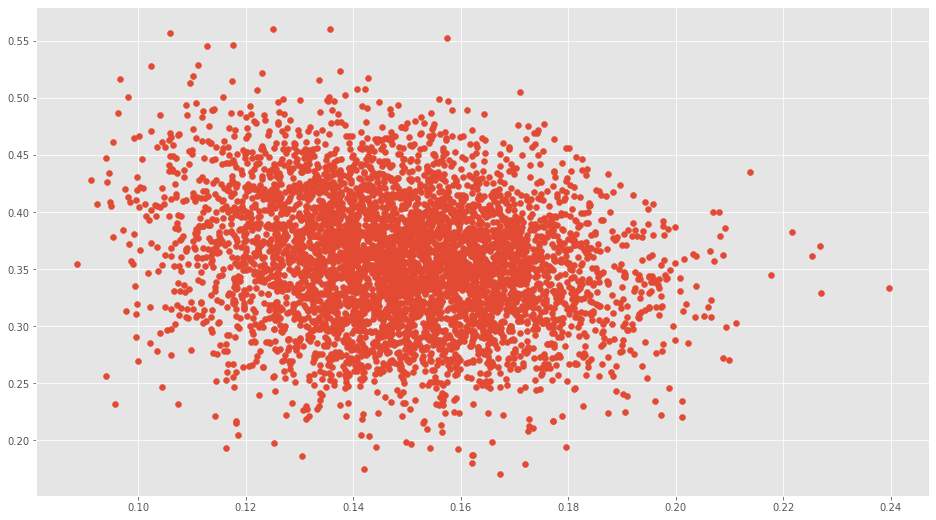

In [39]:
matplotlib.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(16, 9))
plt.scatter(pf_ac,pf_er)

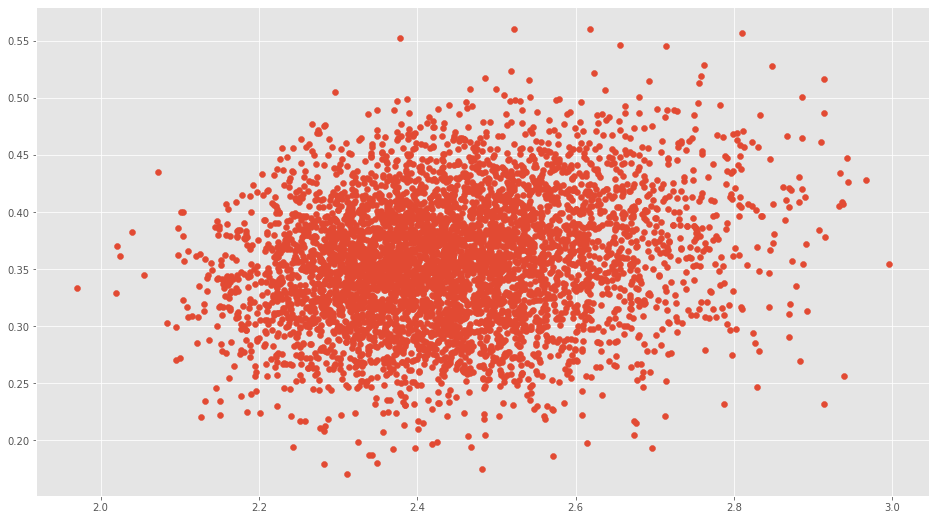

In [40]:
matplotlib.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(16, 9))
plt.scatter(pf_dr,pf_er)

In [ ]:
pca=PCA()
pca.fit(pf_universe.covar_mtxs[1]).explained_variance_ratio_

In [20]:
pf_universe.pf_eigenvalue_explvars

NumOfPosn            72                ...            0               
SimID                 4             3  ...             1             0
1          8.290020e-01  8.290020e-01  ...  8.290020e-01  8.290020e-01
2          7.712403e-02  7.712403e-02  ...  7.712403e-02  7.712403e-02
3          1.781357e-02  1.781357e-02  ...  1.781357e-02  1.781357e-02
4          1.458462e-02  1.458462e-02  ...  1.458462e-02  1.458462e-02
5          7.397287e-03  7.397287e-03  ...  7.397287e-03  7.397287e-03
..                  ...           ...  ...           ...           ...
502        7.635165e-33  7.635165e-33  ...  7.635165e-33  7.635165e-33
503        7.635165e-33  7.635165e-33  ...  7.635165e-33  7.635165e-33
504        7.635165e-33  7.635165e-33  ...  7.635165e-33  7.635165e-33
505        4.910722e-34  4.910722e-34  ...  4.910722e-34  4.910722e-34
506        5.525279e-36  5.525279e-36  ...  5.525279e-36  5.525279e-36

[506 rows x 365 columns]

In [7]:
def read_price_data(idx):
  open = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/open_price.csv')
  close = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
  high = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/high_price.csv')
  low = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/low_price.csv')
  bb_live = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/bb_live.csv')
  volume = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/volume.csv')
  print(close.columns[idx])

  open=open.iloc[:,[0,idx]]
  close=close.iloc[:,[0,idx]]
  high=high.iloc[:,[0,idx]]
  low=low.iloc[:,[0,idx]]
  bb_live=bb_live.iloc[:,[0,idx]]
  volume=volume.iloc[:,[0,idx]]

  open['date'] = pd.to_datetime(open['date'])
  open=open.set_index('date')

  close['date'] = pd.to_datetime(close['date'])
  close=close.set_index('date')

  high['date'] = pd.to_datetime(high['date'])
  high=high.set_index('date')

  low['date'] = pd.to_datetime(low['date'])  
  low=low.set_index('date')

  bb_live['date'] = pd.to_datetime(bb_live['date'])
  bb_live=bb_live.set_index('date')

  volume['date'] = pd.to_datetime(volume['date'])
  volume=volume.set_index('date')

  result = pd.concat([open,high,low,close,volume,bb_live], axis=1).reindex(open.index)
  result.columns = ['open','high','low','close','volume','bb_live']

  result['open'] =result['open'].apply(lambda x: x/result.open[0])
  result['close'] =result['close'].apply(lambda x: x/result.close[0])
  result['high'] =result['high'].apply(lambda x: x/result.high[0])
  result['low'] =result['low'].apply(lambda x: x/result.low[0])
  result['bb_live'] =result['bb_live'].apply(lambda x: x/result.bb_live[0])
  result['volume'] =result['volume'].apply(lambda x: x/result.volume[0])

  return result

def data_load(idx):
  prices = read_price_data(idx)
  tech_ind = add_all_ta_features(prices, open="open", high="high", low="low", close="close", volume="volume")
  secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')
  secondary_index_data=secondary_index_data.set_index('date')

  ind=pd.concat([tech_ind, secondary_index_data], axis=1).reindex(tech_ind.index)
  #ind=tech_ind
  ind=ind.dropna(axis=1,how='all',thresh=2000)
  ind=ind.dropna(axis=0)

  #equity=sp500_hist_data.iloc[:,[0,idx]]
  #missing_values = set(ind.iloc[:, 0]).symmetric_difference(set(equity.iloc[:, 0]))
  #missing_values=list(missing_values)
  #print(len(missing_values))
  #ind = ind[~ind['date'].isin(missing_values)]
  #equity = equity[~equity['date'].isin(missing_values)]
  X=ind.iloc[:,6:]
  y=ind.iloc[:,3]
  return X, y

def input_data(trainx,trainy,index):
  trainx=trainx.to_numpy()
  trainy=trainy.to_numpy()
  trainX, trainY = trainx[:index,:], trainy[:index]
  validX, validY = trainx[index:,:], trainy[index:]
  scaler = StandardScaler()
  trainX=scaler.fit_transform(trainX)
  validX=scaler.transform(validX)
  return trainX, trainY, validX, validY

def remove_features(trainX,trainY):
  corr_matrix=[]
  for idx in range(0,trainX.shape[1]): 
    corr=np.corrcoef(trainX.iloc[:,idx].to_numpy(),trainY.to_numpy())
    corr_matrix.append(corr[0,1]*100)
    idx_list=[]
  for i,val in enumerate(corr_matrix):
    if (val<=5 and val>=-5):
      idx_list.append(i)
    #elif (val>=98):
    #  idx_list.append(i)
  trainX=trainX.drop(columns=trainX.columns[idx_list])
  return trainX,trainY, corr_matrix

def sp500_returns():
  close = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
  close = close.set_index('date')
  #close = close.fillna(0)
  close = close.pct_change()[1:]
  #close = close.sort_values(by=list(close.columns),axis=0)
  return close    

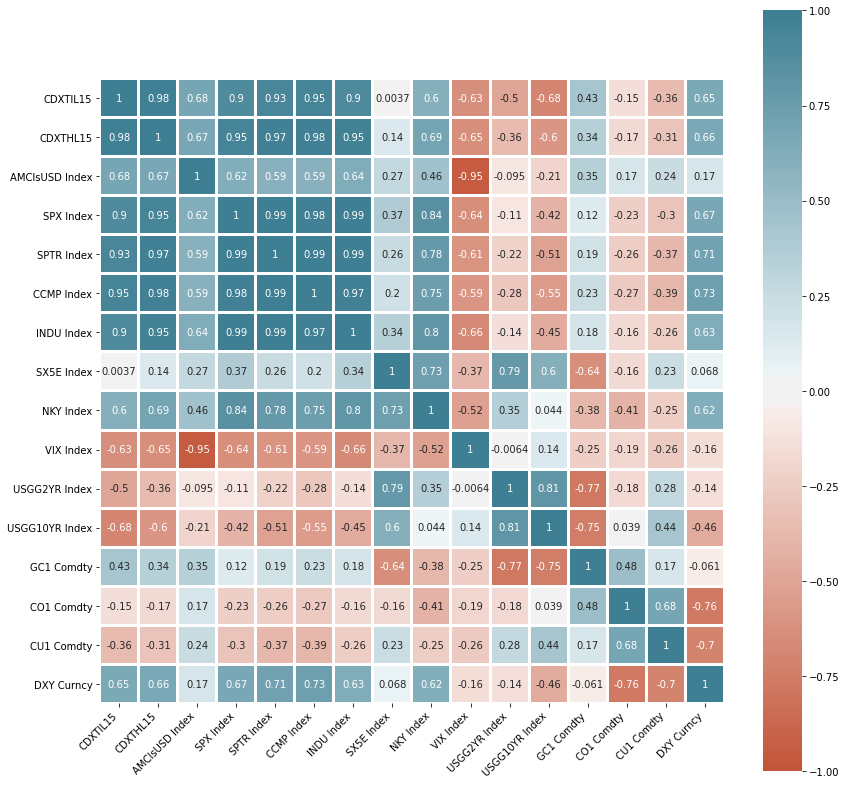

In [16]:
import seaborn as sns
# Step 0 - Read the dataset, calculate column correlations and make a seaborn heatmap
fig, ax1 = plt.subplots(figsize=(14, 14))
data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')
data = data.set_index('date')
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidth=2,annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# **Diversification**

In [ ]:
sp500_companies = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/company_data.csv')
sp500_companies.tail()

,tablerownames,ticker,company,constituentStart,constituentEnd,industryCode,industry
674,679,YHOO.US Equity,Yahoo! Inc,1999-12-07,2017-06-16,451010,Internet Software & Services
675,680,YUM.US Equity,Yum! Brands Inc.,1997-10-06,NaN,253010,"Hotels, Restaurants & Leisure"
676,681,ZBH.US Equity,Zimmer Biomet Holdings Inc,2001-08-06,NaN,351010,Health Care Equipment & Supplies
677,682,ZION.US Equity,Zions Bancorp,2001-06-22,NaN,401010,Commercial Banks
678,683,ZTS.US Equity,Zoetis Inc,2013-06-21,NaN,352020,Pharmaceuticals


In [ ]:
sp500_companies['company'].unique()

In [ ]:
print(sp500_companies['industry'].value_counts(normalize=True)[:30]*50)

Oil, Gas & Consumable Fuels                       2.724595
Equity Real Estate Investment Trusts (REITs)      2.430044
Health Care Providers & Services                  1.988218
Insurance                                         1.840943
Specialty Retail                                  1.840943
Health Care Equipment & Supplies                  1.767305
Capital Markets                                   1.767305
Commercial Banks                                  1.620029
Machinery                                         1.546392
IT Services                                       1.546392
Semiconductors & Semiconductor Equipment          1.546392
Media                                             1.472754
Energy Equipment & Services                       1.472754
Chemicals                                         1.399116
Food Products                                     1.178203
Pharmaceuticals                                   1.178203
Multi-Utilities                                   1.1782

An Equal weighted portfolio with 10 stocks, rebalanced each day with that days 10 highest returns generating stocks.

In [ ]:
secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')
secondary_index_data = secondary_index_data['SPX Index']
secondary_index_data=secondary_index_data.pct_change()
return_matrix = sp500_returns()
n_stocks=20
weights=[1/n_stocks]*n_stocks
cum_return=[]
for day in range(0, return_matrix.shape[0]):
  day_return=[]
  for comp in range(0, return_matrix.shape[1]):
    day_return.append(return_matrix.iloc[day,comp])
  day_return = [x for x in day_return if (str(x) != 'nan' and x<1)]
  day_return.sort(reverse=True)
  day_return=day_return[:n_stocks]
  res_list = [weights[i] * day_return[i] for i in range(len(day_return))]
  cum_return.append(sum(res_list))

matplotlib.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(16, 9))
ax2 = ax1.twinx()
ax1.plot(cum_return,color='red')
ax1.plot(secondary_index_data,color='blue',alpha=0.5)
ax1.legend(['Equal Weighted Portfolio Returns', 'S&P500 Index Returns'])  

In [ ]:
sp500_hist_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/close_price.csv')
sp500_companies = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/company_data.csv')
secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/S&P500/data/secondary_data.csv')

### **Support Vector Regression**

In [ ]:
tuned_parameters = [{'kernel': ['poly'], 'gamma': ['auto'],
                     'C': [1, 10, 100, 1000], 'degree':[1,2],'epsilon':[0.1],
                    'coef0':[1,2,3,4,5,6,7,8,9,10]}]
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

score=['mean_squared_error']
ind, equity = data_load(300)
days=100
ind,equity,corr=remove_features(ind,equity)
trainX, trainY, validX, validY = input_data(ind,equity,days)
print(trainX.shape, trainY.shape, validX.shape, validY.shape)

model = GridSearchCV(
        SVR(), tuned_parameters
    )
model.fit(trainX, trainY)
#model = svr_poly.fit(trainX, trainY)
print(model.score(validX[:-1],validY[1:]))

(100, 70) (100,) (1775, 70) (1775,)
0.8951552030297335


In [ ]:
model.best_params_

{'C': 1000,
 'coef0': 10,
 'degree': 2,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'poly'}

In [ ]:
trainX[:-1].shape, trainY[1:].shape

((99, 70), (99,))

In [84]:
svr_poly = SVR(kernel='poly', C=250, gamma='auto', degree=1, epsilon=.1, coef0=10)
svr_linear = SVR(kernel='linear',C=100,epsilon=0.1)
ind, equity = data_load(100)
days=400
ind,equity,corr=remove_features(ind,equity)
trainX, trainY, validX, validY = input_data(ind,equity,days)
print(trainX.shape, validX.shape, trainY.shape, validY.shape)
model_p = svr_poly.fit(trainX, trainY)
model_l = svr_linear.fit(trainX, trainY,)
print(mean_absolute_error(validY[1:], model_p.predict(validX[:-1])), model_p.score(validX[:-1],validY[1:]))
#print(model_p.score(validX,validY),model_l.score(validX,validY))

BWA.US Equity
(400, 64) (1475, 64) (400,) (1475,)
0.14578636197537512 0.7167295066989658


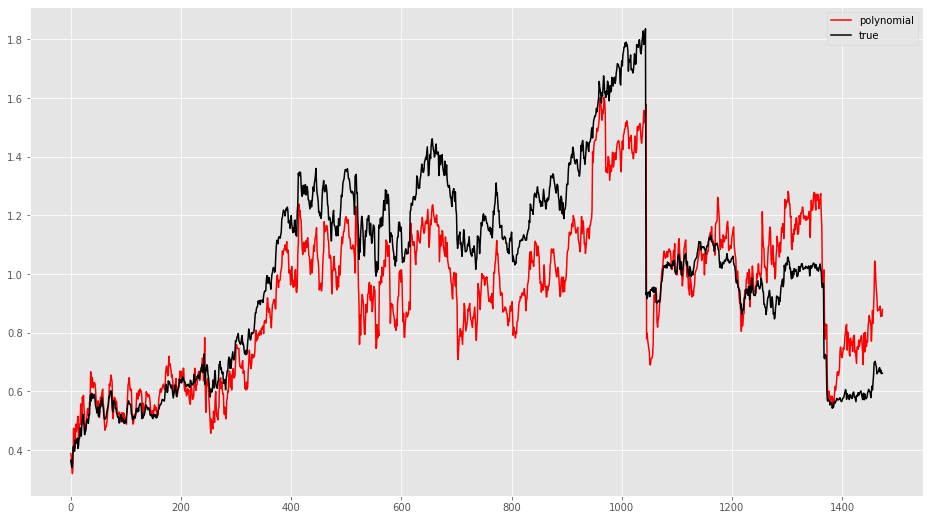

In [85]:
#ypred_stack = stack.predict(validX)
ypred_poly = model_p.predict(validX[:-1])
matplotlib.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(16, 9))
#ax2 = ax1.twinx()
# ax1.plot(ypred_stack,color='green')
ax1.plot(ypred_poly,color='red')
ax1.plot(validY[1:],color='black')
ax1.legend(['polynomial','true'])

### **LightGBM**

In [ ]:
#model parameters
param = {'num_leaves':300, 'objective':'mse','max_depth':20,'learning_rate':0.1,'max_bin':200, 'seed':15, 'verbose': -1}
param['metric'] = ['mse']

#model variables initialisation
model=None
evals_result = {} #store batch results
cum_results = {'training':[], 'valid_1':[]} #store all results

In [ ]:
#training loop
trainValidSplit = 0.75
roundPerBatch = 5000
#trainx=ind.to_numpy()
#trainy=equity.to_numpy()

In [ ]:
#training loop
#build training and validation gbm dataset objects
for i in range(43,44):
  ind, equity = data_load(i)
  newX,newY=remove_features(ind,equity)
  trainX, trainY, validX, validY = input_data(newX,newY)
  train_data = lgb.Dataset(trainX, label=trainY)
  validation_data = lgb.Dataset(validX,label=validY)
  #train model
  model = lgb.train(param, train_data, roundPerBatch,
                      valid_sets=[train_data, validation_data],
                      evals_result=evals_result,
                      verbose_eval=1,init_model=model)
  cum_results['training'] += (evals_result['training']['l2'])
  cum_results['valid_1'] += (evals_result['valid_1']['l2'])
  #if i != int((sp500_hist_data.shape[1]/2)-1):
   # del ind,equity,trainX, trainY, validX, validY,train_data,validation_data

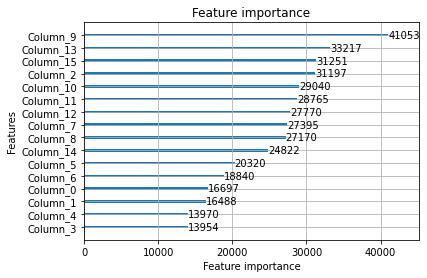

In [ ]:
lgb.plot_importance(model, max_num_features=16);

### **Quantile Regression**

In [ ]:
ind, equity = data_load(43)
ind,equity,corr=remove_features(ind,equity)
#ind.info()
trainX, trainY, validX, validY = input_data(ind,equity,500)
print(trainX.shape, trainY.shape, validX.shape, validY.shape)
mod = sm.regression.quantile_regression.QuantReg(trainY, trainX)
model = mod.fit(q=.5,kernel='gau')
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(500, 23) (500,) (1375, 23) (1375,)
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               -5.755
Model:                       QuantReg   Bandwidth:                       1.784
Method:                 Least Squares   Sparsity:                   6.580e+291
Date:                Wed, 16 Sep 2020   No. Observations:                  500
Time:                        15:47:35   Df Residuals:                      477
                                        Df Model:                           23
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1244        nan        nan        nan         nan         nan
x2             6.3341        nan        nan        nan         nan         nan
x3             0.5473        nan        nan        nan         nan         nan
x4             0

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:206: RuntimeWarning: overflow encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### **Support Vector Quantile Regression**

In [ ]:
!pip3 install liquidSVM

     |████████████████████████████████| 563kB 4.9MB/s 
  Created wheel for liquidSVM: filename=liquidSVM-1.0.1-cp36-cp36m-linux_x86_64.whl size=2578630 sha256=692a7a1a56bf1a14fc82451cd6020a20de808647eeee3d9b5f78701ff92f6644
  Stored in directory: /root/.cache/pip/wheels/85/3f/fc/daaad6cff352e71e2eab30b54adaec90108fc2908324c0511a
Successfully built liquidSVM


In [ ]:
from liquidSVM import LiquidData,qtSVM

In [ ]:
reg = LiquidData('reg-1d')
print(reg.train)

{'data': array([[0.28986675],
       [0.19561529],
       [0.23956186],
       ...,
       [0.90154848],
       [0.95844949],
       [1.06665809]]), 'target': array([0.42561854, 0.36602415, 0.33559088, ..., 0.44949226, 0.38824736,
       0.49917251]), 'DESCR': 'reg-1d (train)'}


In [ ]:
quantiles_list = [ 0.05, 0.1, 0.5, 0.9, 0.95 ]

ind, equity = data_load(43)
ind,equity,corr=remove_features(ind,equity)
trainX, trainY, validX, validY = input_data(ind,equity,500)
print(trainX.shape, trainY.shape, validX.shape, validY.shape)
print(data.shape)
model = qtSVM(reg.train, weights=quantiles_list,)

result, err = model.test(reg.test)
err[:,0]

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(500, 70) (500,) (1375, 70) (1375,)


ValueError: ignored